# SKLearn SVM

## Data Use Agreements
The data used for this project were provided in part by OASIS and ADNI.

OASIS-3: Principal Investigators: T. Benzinger, D. Marcus, J. Morris; NIH P50 AG00561, P30 NS09857781, P01 AG026276, P01 AG003991, R01 AG043434, UL1 TR000448, R01 EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly.

Data collection for this project was done through the Alzheimer's Disease Neuroimaging Initiative (ADNI) (National Institutes of Health Grant U01 AG024904) and DOD ADNI (Department of Defense award number W81XWH-12-2-0012). ADNI is funded by the National Institute on Aging, the National Institute of Biomedical Imaging and Bioengineering, and through generous contributions from the following: AbbVie, Alzheimer’s Association; Alzheimer’s Drug Discovery Foundation; Araclon Biotech; BioClinica, Inc.; Biogen; Bristol-Myers Squibb Company; CereSpir, Inc.; Cogstate; Eisai Inc.; Elan Pharmaceuticals, Inc.; Eli Lilly and Company; EuroImmun; F. Hoffmann-La Roche Ltd and its affiliated company Genentech, Inc.; Fujirebio; GE Healthcare; IXICO Ltd.; Janssen Alzheimer Immunotherapy Research & Development, LLC.; Johnson & Johnson Pharmaceutical Research & Development LLC.; Lumosity; Lundbeck; Merck & Co., Inc.; Meso Scale Diagnostics, LLC.; NeuroRx Research; Neurotrack Technologies; Novartis Pharmaceuticals Corporation; Pfizer Inc.; Piramal Imaging; Servier; Takeda Pharmaceutical Company; and Transition Therapeutics. The Canadian Institutes of Health Research is providing funds to support ADNI clinical sites in Canada. Private sector contributions are facilitated by the Foundation for the National Institutes of Health (www.fnih.org). The grantee organization is the Northern California Institute for Research and Education, and the study is coordinated by the Alzheimer’s Therapeutic Research Institute at the University of Southern California. ADNI data are disseminated by the Laboratory for Neuro Imaging at the University of Southern California.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Loading dataset
df = pd.read_csv('../../Data/OASIS/oasis_3.csv')

In [3]:
df.head()

,Subject,MR ID,id,Age,M/F,dx1,mmse,cdr,apoe,TOTAL_HIPPOCAMPUS_VOLUME,...,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
0,OAS30001,OAS30001_MR_d3132,OAS30001_Freesurfer53_d3132,73.0,F,Cognitively normal,30.0,0.0,23.0,6861.9,...,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
1,OAS30001,OAS30001_MR_d0129,OAS30001_Freesurfer53_d0129,65.0,F,Cognitively normal,30.0,0.0,23.0,7678.9,...,187528.786036,379446.180091,50687.0,517683.180091,8.105851e+05,184600.488060,182662.445419,367262.933479,70168.1,69483.8
2,OAS30001,OAS30001_MR_d2430,OAS30001_Freesurfer53_d2430,71.0,F,Cognitively normal,30.0,0.0,23.0,7105.9,...,178872.680224,357784.489639,49058.0,487405.489639,7.779313e+05,175955.968883,178172.812666,354128.781549,67905.7,68000.2
3,OAS30001,OAS30001_MR_d0757,OAS30001_Freesurfer53_d0757,67.0,F,Cognitively normal,29.0,0.0,23.0,7648.2,...,177566.874682,362040.150904,50071.0,500699.150904,7.993419e+05,185224.779932,188151.990316,373376.770247,69142.3,68558.8
4,OAS30002,OAS30002_MR_d2345,OAS30002_Freesurfer53_d2345,73.0,M,Cognitively normal,29.0,0.0,34.0,7833.2,...,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3


## Data Preprocessing

In [4]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
df = df.dropna(axis=1, how='all') # Drop any empty columns
df = df.dropna(axis=0, how='any') # Drop any rows with empty values 
df = df.rename(columns={'id':'Freesurfer ID', 'dx1':'Diagnosis', 
                        'TOTAL_HIPPOCAMPUS_VOLUME':'TotalHippocampusVol'}) # Rename columns
df = df.drop_duplicates(subset='Subject', keep='first') # Keep only the first visit; this is possible because
                                                        # df is sorted by age
df = df.reset_index(drop=True) # Reset the index
df = df.set_index('Subject')

In [6]:
cols = df.columns.tolist()
cols[2], cols[4] = cols[4], cols[2]
df = df[cols]

In [7]:
# This shows that CDR is a good value to separate dementia vs control patients
df.loc[df['cdr'] >= 0.5]['Diagnosis'].value_counts()

AD Dementia                              163
uncertain dementia                        59
DLBD- primary                             11
AD dem w/depresss- not contribut           8
Unc: ques. Impairment                      6
Frontotemporal demt. prim                  6
AD dem Language dysf with                  6
AD dem Language dysf after                 6
AD dem w/depresss- contribut               5
Dementia/PD- primary                       5
0.5 in memory only                         5
Vascular Demt- primary                     4
AD dem w/oth (list B) contribut            3
AD dem distrubed social- with              2
Unc: impair reversible                     2
DAT                                        2
AD dem w/oth (list B) not contrib          2
AD dem Language dysf prior                 2
Non AD dem- Other primary                  2
AD dem w/CVD contribut                     2
AD dem cannot be primary                   2
AD dem w/Frontal lobe/demt at onset        1
AD dem w/P

In [8]:
df.loc[df['cdr'] < 0.5, 'Diagnosis'] = 'control'
df.loc[~(df['cdr'] < 0.5), 'Diagnosis'] = 'dementia'
df['Diagnosis'].unique()

array(['control', 'dementia'], dtype=object)

In [9]:
# 0 indicates control, 1 indicates dementia
df['Diagnosis'].value_counts()

control     712
dementia    310
Name: Diagnosis, dtype: int64

In [10]:
df.loc[df['Diagnosis'] == 'control', 'Diagnosis'] = 0
df.loc[df['Diagnosis'] == 'dementia', 'Diagnosis'] = 1

<AxesSubplot:xlabel='Diagnosis', ylabel='count'>

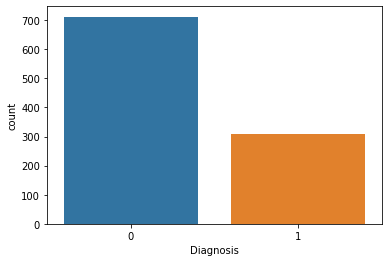

In [11]:
sns.countplot(df['Diagnosis'])

In [12]:
df.head(7)

,MR ID,Freesurfer ID,Diagnosis,M/F,Age,mmse,cdr,apoe,TotalHippocampusVol,IntraCranialVol,...,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
Subject,,,,,,,,,,,,,,,,,,,,,
OAS30001,OAS30001_MR_d3132,OAS30001_Freesurfer53_d3132,0,F,73.0,30.0,0.0,23.0,6861.9,1.186091e+06,...,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
OAS30002,OAS30002_MR_d2345,OAS30002_Freesurfer53_d2345,0,M,73.0,29.0,0.0,34.0,7833.2,1.714636e+06,...,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3
OAS30003,OAS30003_MR_d2682,OAS30003_Freesurfer53_d2682,0,F,66.0,29.0,0.0,33.0,7983.5,1.405092e+06,...,209641.219733,414466.938306,59379.0,557900.938306,9.299305e+05,213905.159729,222232.368895,436137.528624,76695.5,78697.9
OAS30004,OAS30004_MR_d2232,OAS30004_Freesurfer53_d2232,0,F,61.0,30.0,0.0,23.0,8525.1,1.443177e+06,...,206884.661369,420746.332475,53910.0,566477.332475,9.709780e+05,242595.702097,233016.992108,475612.694206,87710.1,84634.9
OAS30005,OAS30005_MR_d2377,OAS30005_Freesurfer53_d2377,0,F,54.0,30.0,0.0,33.0,9298.2,1.554566e+06,...,224311.450543,450055.106418,63545.0,611117.106418,9.867349e+05,229534.963360,230927.823126,460462.786487,82224.0,81421.3
OAS30006,OAS30006_MR_d2341,OAS30006_Freesurfer53_d2341,0,M,68.0,30.0,0.0,33.0,7634.1,1.946884e+06,...,237733.402077,472739.331515,58907.0,643328.331515,1.147571e+06,277185.190999,273057.137812,550242.328811,101915.0,99983.6
OAS30007,OAS30007_MR_d0061,OAS30007_Freesurfer53_d0061,1,M,71.0,28.0,0.5,24.0,8164.0,1.641880e+06,...,227909.170952,452008.699617,53490.0,608098.699617,9.575827e+05,206922.892386,206879.116423,413802.008808,84418.8,83142.6


In [13]:
df = df.drop(['MR ID', 'Freesurfer ID', 'M/F', 'cdr', 'apoe'], axis=1) # Drop categorical and redundant columns
# df = df.drop(['lhCortexVol', 'rhCortexVol', 'lhCorticalWhiteMatterVol', 'rhCorticalWhiteMatterVol', 'L.SurfArea', 'R.SurfArea'], axis=1) # Test drop to reduce dimensionality

In [14]:
df.head()

,Diagnosis,Age,mmse,TotalHippocampusVol,IntraCranialVol,lhCortexVol,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
Subject,,,,,,,,,,,,,,,,
OAS30001,0,73.0,30.0,6861.9,1.186091e+06,181943.698754,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
OAS30002,0,73.0,29.0,7833.2,1.714636e+06,227101.503019,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3
OAS30003,0,66.0,29.0,7983.5,1.405092e+06,204825.718573,209641.219733,414466.938306,59379.0,557900.938306,9.299305e+05,213905.159729,222232.368895,436137.528624,76695.5,78697.9
OAS30004,0,61.0,30.0,8525.1,1.443177e+06,213861.671106,206884.661369,420746.332475,53910.0,566477.332475,9.709780e+05,242595.702097,233016.992108,475612.694206,87710.1,84634.9
OAS30005,0,54.0,30.0,9298.2,1.554566e+06,225743.655875,224311.450543,450055.106418,63545.0,611117.106418,9.867349e+05,229534.963360,230927.823126,460462.786487,82224.0,81421.3


In [15]:
df.Diagnosis.value_counts()

0    712
1    310
Name: Diagnosis, dtype: int64

In [16]:
# Separate the dataset into features and response variable
X = df.drop(['Diagnosis'], axis=1)
y = df['Diagnosis']
y=y.astype('int')

In [17]:
# Splitting data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(817, 15) (817,) (205, 15) (205,)


In [19]:
# Applying mixmax scaling to data
"""
The purpose of this is to prevent any one column from 'overpowering' the effect
of another column due to it's values being large. It would scale the 10^6 scale
of data in the IntraCranialVol and the 10^1 scale of data in age into the same
range of data, such as between 0 and 1.
"""
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## SVM

In [20]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, recall_score, roc_curve, auc, classification_report, plot_confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

## Testing to see what kernel performs the best

### A large portion of this code is taken from a [publicly available notebook](https://www.kaggle.com/hyunseokc/detecting-early-alzheimer-s#6.C-SVM) by Hyunseok Choi.

##### This section is commented out since it takes a very long time to run and really only needs to be run once.

In [21]:
# best_score = 0

# for c_parameter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter C
#     for gamma_parameter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter gamma
#         for k_parameter in ['rbf', 'poly', 'sigmoid', 'linear']: # iterate over the values we need to try for the kernel parameter
#             n_estimators = 10
#             svmModel = BaggingClassifier(SVC(kernel=k_parameter, C=c_parameter, gamma=gamma_parameter, cache_size=7000, random_state=0), 
#                                          max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1)
#             #svmModel = SVC(kernel=k_parameter, C=c_parameter, gamma=gamma_parameter, cache_size=7000, n_jobs=-1) #define the model
            
#             # perform cross-validation
#             scores = cross_val_score(svmModel, X_train, y_train, cv=5, scoring='accuracy')
#             # the training set will be split internally into training and cross validation

#             # compute mean cross-validation accuracy
#             score = np.mean(scores)
#             # if we got a better score, store the score and parameters
#             if score > best_score:
#                 print(f'Currently on: {c_parameter}, {gamma_parameter}, {k_parameter}')
#                 print(f'{k_parameter}: {score}')
#                 best_score = score #store the score 
#                 best_parameter_c = c_parameter #store the parameter c
#                 best_parameter_gamma = gamma_parameter #store the parameter gamma
#                 best_parameter_k = k_parameter
            

# # rebuild a model with best parameters to get score 
# SelectedSVMmodel = SVC(C=best_parameter_c, gamma=best_parameter_gamma, kernel=best_parameter_k, random_state=0).fit(X_train, y_train)

# test_score = SelectedSVMmodel.score(X_test, y_test)
# PredictedOutput = SelectedSVMmodel.predict(X_test)
# test_recall = recall_score(y_test, PredictedOutput, pos_label=1)
# fpr, tpr, thresholds = roc_curve(y_test, PredictedOutput, pos_label=1)
# test_auc = auc(fpr, tpr)
# print("Best accuracy on cross validation set is:", best_score)
# print("Best parameter for c is: ", best_parameter_c)
# print("Best parameter for gamma is: ", best_parameter_gamma)
# print("Best parameter for kernel is: ", best_parameter_k)
# print("Test accuracy with the best parameters is", test_score)
# print("Test recall with the best parameters is", test_recall)
# print("Test recall with the best parameter is", test_auc)

## Linear SVM based on the best kernel parameters found

In [22]:
y_train

Subject
OAS30878    1
OAS30238    1
OAS30410    1
OAS30006    0
OAS30405    0
           ..
OAS30966    0
OAS30225    0
OAS30726    0
OAS30644    0
OAS30790    0
Name: Diagnosis, Length: 817, dtype: int64

In [23]:
SVCmodel = SVC(C=100, kernel='linear', random_state=0).fit(X_train, y_train)
score = SVCmodel.score(X_test, y_test)
print("Accuracy of Linear SVC:", score)

Accuracy of Linear SVC: 0.8682926829268293


In [24]:
pred_svm = SVCmodel.predict(X_test)
correct_preds = np.sum(pred_svm == y_test)
print(correct_preds/y_test.size)

0.8682926829268293


In [25]:
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       152
           1       0.76      0.72      0.74        53

    accuracy                           0.87       205
   macro avg       0.83      0.82      0.82       205
weighted avg       0.87      0.87      0.87       205



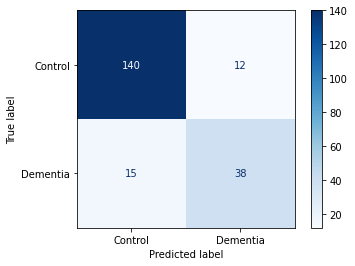

In [26]:
plot_confusion_matrix(SVCmodel, X_test, y_test, display_labels=['Control', 'Dementia'], cmap=plt.cm.Blues)